# **Import**

In [1]:
from obspy import read
import plotly.graph_objects as go
from scipy.signal import spectrogram, hanning
from scipy import signal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# **Create Geometry**

In [2]:
def CreateGeometry(f_number,f_distance,equidistant=True):
    global fig
    global x
    global z
    fig = go.Figure()
    list_floor = []
    
    if equidistant == True:
        
        f_total = f_number * f_distance
        
        z = np.arange(0,f_total+f_distance,f_distance)
        x = np.zeros(len(z))
        
        fig.add_trace(go.Scatter(x=x, y=z,
                    mode='lines+markers',
                    name='Floor'))
        
        fig.update_traces(marker=dict(size=14,
                              line=dict(width=2,
                                        color='DarkSlateGrey')))
        
        
        fig.write_html("Floor.html")
        
    
    if equidistant == False:
        
        while True:
            

            q_floor = input("Floor Distance :")
            
            q_floor = int(q_floor)
            
            list_floor.append(q_floor)
        
            if q_floor == 0:
                list_floor.remove(0)
                break
                
        z = list_floor
        x = np.zeros(len(z))
        
        fig.add_trace(go.Scatter(x=x, y=z,
                    mode='lines+markers',
                    name='Floor'))
        
        fig.update_traces(marker=dict(size=14,
                              line=dict(width=2,
                                        color='DarkSlateGrey')))     
    

        fig.write_html("Floor.html")
    
    
            

In [3]:
CreateGeometry(3,3,equidistant=True)

# ***PlaceSensor***

In [4]:
floor_list = []
direction_list = []
channel_list = []


def placeSensor(floor,channel_name,direction="X"):
    
    fig.add_trace(go.Scatter(x=[0], y=[floor],
                         marker=dict(size=20, color="red"),
        mode='markers+text',
        name=channel_name,
        text=[channel_name],
        textposition='middle right'))
    
    floor_list.append(floor)
    direction_list.append(direction)
    channel_list.append(channel_name)
    
    
    fig.write_html("Floor3.html")
    


In [5]:
placeSensor(3,"5894_5t64n0_20200308_0400.gcf")

In [6]:
placeSensor(6,"5894_5t64n0_20200217_1500.gcf")

In [7]:
placeSensor(9,"5894_5t64n0_20201030_1100.gcf")

In [8]:
mean_S = pd.DataFrame()

def Analysis(count,window_size,overlap,fs,filtertype="bandpass",**filteroptions):
    global st
    global var_count
    st = read(channel_list[0])
    var_count = count
    for a in range(len(channel_list)-1):
        st += read(channel_list[1 + a])
        
        st = st.filter(filtertype,**filteroptions)
        st = st.detrend("spline", order=3, dspline=200)
        
        for i in range(len(channel_list)-1):
            M = window_size
            NFFT = M
            win = signal.windows.hamming(M)
            overlap = overlap /100
            overlap_samples = int(round(M*overlap)) # overlap in samples
            t, f, S = spectrogram(st[i].data/(round(count)* 9.81),fs=fs,window=win,nperseg=M,noverlap=overlap_samples,nfft=NFFT)

            avg_S = np.mean(S,axis=1)
            mean_S["xf"] = t
            mean_S[channel_list[i]] = avg_S

In [9]:
Analysis(318870.64,4096,66,200,"bandpass",freqmin=1,freqmax=20)

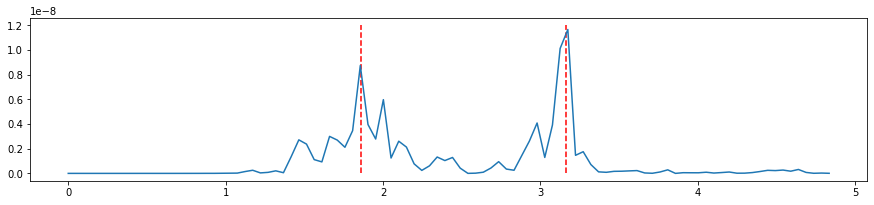

In [10]:
plt.figure(figsize=[15,3])
plt.plot(mean_S['xf'][0:100],mean_S['5894_5t64n0_20200308_0400.gcf'][0:100])
plt.vlines(1.86,0,1.2*10**-8, linestyles='dashed',color="red")
plt.vlines(3.16,0,1.2*10**-8, linestyles='dashed',color="red")

# ***ShowAnimation*** 

In [11]:
import scipy.integrate as it



def showAnimation(modfreq,min_length,max_length,shape_steps,all_length = True):
    global max_df
    global disp_df
    st1 = st.copy()
    st1 = st1.filter("bandpass",freqmin=modfreq-0.2,freqmax=modfreq+0.2)
    
    disp_df = pd.DataFrame()
    
    for a in range(3): # Add three reference line
        fig.add_trace(go.Scatter(x=[0], y=[0],
                         mode="lines",
                         name="Reference Line"))
        
        
    for channel in range(len(channel_list)):
        
        X = st1[channel].data /(round(var_count)* 9620)
        velocity = it.cumtrapz(X,initial=0)
        disp_df[channel_list[channel]] = it.cumtrapz(velocity,initial=0)
    
    
    
    if all_length == True:
        min_length = 0
        max_length = len(st[0].data)
        
        print(min_length,max_length)
        
        
    else:
        max_df1 = disp_df[min_length:max_length].max()
        max_df = max_df1.max()
        
        xx = disp_df[channel_list[0]][min_length:max_length]
        xx1 = disp_df[channel_list[1]][min_length:max_length]
        xx2 = disp_df[channel_list[2]][min_length:max_length]
        
        repeat = np.repeat(floor_list[0],len(disp_df[channel_list[0]][min_length:max_length]))
        repeat1 = np.repeat(floor_list[1],len(disp_df[channel_list[1]][min_length:max_length]))
        repeat2 = np.repeat(floor_list[2],len(disp_df[channel_list[2]][min_length:max_length]))
        
        
        xend = np.repeat(0,len(disp_df[channel_list[0]][min_length:max_length]))
        xnoe = np.repeat(0,len(disp_df[channel_list[0]][min_length:max_length]))
        

        
    fig.frames=[go.Frame(
        data=[go.Scatter(x=x, y=z,
                    mode='lines+markers',
                    name='Floor'),
            
            
            go.Scatter(
            
            x=[xx[k]],
            y=[repeat[k]],
            mode="markers",
            marker=dict(color="red", size=20)),
              
            go.Scatter(
            
            x=[xx1[k]],
            y=[repeat1[k]],
            mode="markers",
            marker=dict(color="red", size=20)),
              
            go.Scatter(
            
            x=[xx2[k]],
            y=[repeat2[k]],
            mode="markers",
            marker=dict(color="red", size=20)),
            
            go.Scatter(
            
            x=[xend[k],xx[k]],
            y=[xnoe[k],repeat[k]],
            mode="lines",
            name = "Reference Line",
            line=dict(color='black', width=2,dash='dash')),
             
             
            go.Scatter(
            
            x=[xx[k],xx1[k]],
            y=[repeat[k],repeat1[k]],
            mode="lines",
            name = "Reference Line",
            line=dict(color='black', width=2,dash='dash')),
              
            go.Scatter(
            
            x=[xx1[k],xx2[k]],
            y=[repeat1[k],repeat2[k]],
            mode="lines",
            name = "Reference Line",
            line=dict(color='black', width=2,dash='dash'))
             
             
             ])
            
            
            for k in range(1,len(disp_df[channel_list[0]][min_length:max_length]),shape_steps)
            
           ] 
    
    fig.layout=go.Layout(
        xaxis=dict(range=[-max_df, max_df], autorange=True, zeroline=False),
        yaxis=dict(range=[0, 12], autorange=False, zeroline=False),
        title_text="Mode Shape Animation", hovermode="closest",
        updatemenus=[dict(type="buttons",
                          buttons=[dict(label="Play",
                                        method="animate",
                                        args=[None])])])
    
    
    
    fig.write_html("Function.html")
                            

In [12]:
showAnimation(3.16,0,50,10,all_length = False)

xx = np.linspace(0,1,5)
xx1 = np.linspace(0,1.5,5)
xx2 = np.linspace(0,2,5)


repeat = np.repeat(floor_list[0],5)
repeat1 = np.repeat(floor_list[1],5)
repeat2 = np.repeat(floor_list[2],5)

xend = np.repeat(0,5)
xnoe = np.repeat(0,5)

fig.frames=[go.Frame(
        data=[go.Scatter(x=x, y=z,
                    mode='lines+markers',
                    name='Floor'),
            
            
            go.Scatter(
            
            x=[xx[k]],
            y=[repeat[k]],
            mode="markers",
            marker=dict(color="red", size=20)),
              
            go.Scatter(
            
            x=[asd["aa"][k]],
            y=[repeat1[k]],
            mode="markers",
            marker=dict(color="red", size=20)),
              
            go.Scatter(
            
            x=[xx2[k]],
            y=[repeat2[k]],
            mode="markers",
            marker=dict(color="red", size=20)),
            
            go.Scatter(
            
            x=[xend[k],xx[k]],
            y=[xnoe[k],repeat[k]],
            mode="lines",
            name = "Reference Line",
            line=dict(color='black', width=2,dash='dash')          )])
            
            
            for k in range(5)
            
           ]

fig.layout=go.Layout(
        xaxis=dict(range=[-2, 2], autorange=False, zeroline=False),
        yaxis=dict(range=[0, 12], autorange=False, zeroline=False),
        title_text="Kinematic Generation of a Planar Curve", hovermode="closest",
        updatemenus=[dict(type="buttons",
                          buttons=[dict(label="Play",
                                        method="animate",
                                        args=[None])])])

fig.write_html("animation.html")

In [ ]:
disp_df[0:100].plot()

In [ ]:

a = disp_df.max()

In [ ]:
a.max()

In [ ]:
max_df

In [ ]:
import scipy.integrate as it
X = st[1].data
velocity = it.cumtrapz(X,initial=0)
location = it.cumtrapz(velocity,initial=0)


In [ ]:
disp_df[0:100].max()

In [ ]:
fig.write_html("deneme4.html")